# Using python to work with geospatial data

Python has a number of open source, geospatial libraries designed to work with both raster and vector data. In this tutorial we will use import arrays of satellite data using the SpatioTemporal Asset Catalog (STAC) api. Then we will use rioxarray, a library designed to work with rasters (georeferenced arrays) to process and analyze the rasters. We will be using vector data to crop, extract, and summarize raster data located in certain regions of interest defined by raster geometries, mask raster data using vectors, and transform raster data to vector data. We will be using the geopandas library to work with the vector data. 

### Credits
This tutorial is adapted from the excellent resources created by Data Carpentry. Goto https://carpentries-incubator.github.io/geospatial-python/ to view the original tutorials

## How do we access the terabytes of satellite data being created daily?

Every day satellite's collect terabytes of data. It is impractical and not desirable in most cases to access most of this data. Metadata specifications that allow a user to filter these large datesets down to just the data of interest for a given application can be immensely valuable when trying to query satellite data. 

The SpatioTemporal Asset Catalog (STAC) is one such specification. It is a metadata specifiaction that allows data providers to create a catalog of data that can then be programatically filtered and downloaded using a STAC client.

### An example STAC catalog

The nonprofit Radiant Earth in partnership with the geospatial software engineering firm Element 84 mantains a collection of Sentinel 2 imagery on the Amazon Web Services (AWS) platform as part of the Earth Search STAC catalog. 

The catalog can be viewed at: https://radiantearth.github.io/stac-browser/#/external/earth-search.aws.element84.com/v0?.language=en. They also provide a url that serves as an *endpoint* for their STAC catalog that can be queried using a client that adheres to the STAC api spec.

Now let's install and import a client capable of interacting with this STAC api endpoint and establish a connection. We will also install rioxarray. Rioxarray extends the popular xarray library for working with N-dimensional heterogenous arrays with the capabilities of the rasterio raster handling library. 

In [1]:
!pip install sat-search
!pip install rioxarray

  Using cached python_dateutil-2.7.5-py2.py3-none-any.whl (225 kB)
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.2
    Uninstalling python-dateutil-2.8.2:
      Successfully uninstalled python-dateutil-2.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-client 8.2.0 requires python-dateutil>=2.8.2, but you have python-dateutil 2.7.5 which is incompatible.
lisflood-model 4.1.2 requires python-dateutil>=2.8.1, but you have python-dateutil 2.7.5 which is incompatible.
pandas 1.5.3 requires python-dateutil>=2.8.1, but you have python-dateutil 2.7.5 which is incompatible.
pystac-client 0.7.1 requires python-dateutil>=2.8.2, but you have python-dateutil 2.7.5 which is incompatible.
  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Attempting uninstall: python-dateutil
    Found existing insta

In [1]:
import satsearch

SentinelSTAC = satsearch.Search.search( url = "https://earth-search.aws.element84.com/v0" )
print("Found " + str(SentinelSTAC.found()) + "items")

Found 59139809items


## Querying the earth search STAC catalog
We will now query this catalog for Sentinel-2 Cloud Optimized GeoTIFF (COG) files. A COG is a a raster data format that is optimized for being hosted on cloud services. The COG format is based on the normal georeferenced GeoTIFF file format but organizes the data so that partial data access is possible using HTTP range requests. Partial data reads and writes make it so that large satellite images don't have to be transferred in their entirety when only a subset of the data is needed. COG's also have the ability to store lower resolution versions of an image as overlays on top of the original resolution. This pyramidal structure is another feature that prevents having to deal with massive unneccessary data transfers.  

In [2]:
#Define a json point geometry
point= {
  "type": "Point",
  "coordinates": [4.89, 52.37]
}

SentinelSearch = satsearch.Search.search( 
    url = "https://earth-search.aws.element84.com/v0",
    intersects = point,
    collections = ['sentinel-s2-l2a-cogs'] )  # Sentinel-2, Level 2A, COGs

Sentinel_items = SentinelSearch.items()
print(Sentinel_items.summary())

for item in Sentinel_items:
    red_s3 = item.assets['B04']['href']
    print(red_s3)

Items (791):
date                      id                        
2023-05-02                S2A_31UFU_20230502_0_L2A  
2023-04-25                S2A_31UFU_20230425_0_L2A  
2023-04-22                S2A_31UFU_20230422_0_L2A  
2023-04-20                S2B_31UFU_20230420_0_L2A  
2023-04-17                S2B_31UFU_20230417_0_L2A  
2023-04-15                S2A_31UFU_20230415_0_L2A  
2023-04-12                S2A_31UFU_20230412_0_L2A  
2023-04-10                S2B_31UFU_20230410_0_L2A  
2023-04-07                S2B_31UFU_20230407_0_L2A  
2023-04-05                S2A_31UFU_20230405_0_L2A  
2023-04-02                S2A_31UFU_20230402_0_L2A  
2023-03-31                S2B_31UFU_20230331_0_L2A  
2023-03-28                S2B_31UFU_20230328_0_L2A  
2023-03-26                S2A_31UFU_20230326_0_L2A  
2023-03-23                S2A_31UFU_20230323_0_L2A  
2023-03-21                S2B_31UFU_20230321_1_L2A  
2023-03-18                S2B_31UFU_20230318_0_L2A  
2023-03-16                S2A_31U

In [3]:
#Let's inspect the first metadata item in the ItemCollection we just gathered
item = Sentinel_items[9]
print(item.datetime,"\n")
print(item.geometry,"\n")
print(item.properties,"\n")

2023-04-05 10:56:22+00:00 

{'type': 'Polygon', 'coordinates': [[[6.071664488869862, 52.22257539160586], [4.464995307918359, 52.25346561204129], [4.498475093400055, 53.24019917467795], [6.1417542968794585, 53.20819279121764], [6.071664488869862, 52.22257539160586]]]} 

{'datetime': '2023-04-05T10:56:22Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'gsd': 10, 'view:off_nadir': 0, 'proj:epsg': 32631, 'sentinel:utm_zone': 31, 'sentinel:latitude_band': 'U', 'sentinel:grid_square': 'FU', 'sentinel:sequence': '0', 'sentinel:product_id': 'S2A_MSIL2A_20230405T105031_N0509_R051_T31UFU_20230405T162253', 'sentinel:data_coverage': 100, 'eo:cloud_cover': 28.86, 'sentinel:valid_cloud_cover': True, 'sentinel:processing_baseline': '05.09', 'sentinel:boa_offset_applied': True, 'created': '2023-04-05T19:37:31.073Z', 'updated': '2023-04-05T19:37:31.073Z'} 



## Accessing the assets contained in an item

In [4]:
asset = item.assets

In [5]:
for key, asset in asset.items():
    print(f"{key}: {asset['title']}")

thumbnail: Thumbnail
overview: True color image
info: Original JSON metadata
metadata: Original XML metadata
visual: True color image
B01: Band 1 (coastal)
B02: Band 2 (blue)
B03: Band 3 (green)
B04: Band 4 (red)
B05: Band 5
B06: Band 6
B07: Band 7
B08: Band 8 (nir)
B8A: Band 8A
B09: Band 9
B11: Band 11 (swir16)
B12: Band 12 (swir22)
AOT: Aerosol Optical Thickness (AOT)
WVP: Water Vapour (WVP)
SCL: Scene Classification Map (SCL)


In [6]:
# refresh asset dictionary
asset = item.assets

# print thumnail properties
print(asset['thumbnail'])

{'title': 'Thumbnail', 'type': 'image/png', 'roles': ['thumbnail'], 'href': 'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/31/U/FU/2023/4/5/0/preview.jpg'}


In [7]:
# Get the download link for the thumbnail image
asset["thumbnail"]['href']

'https://roda.sentinel-hub.com/sentinel-s2-l1c/tiles/31/U/FU/2023/4/5/0/preview.jpg'

## Accessing raster data

Now let's access some rasterdata. We will use the rioxarray library.

In [8]:
import rioxarray
b01_href = asset["B01"]['href']
b01 = rioxarray.open_rasterio(b01_href)
print(b01)

<xarray.DataArray (band: 1, y: 1830, x: 1830)>
[3348900 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6.001e+05 6.002e+05 ... 7.097e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0


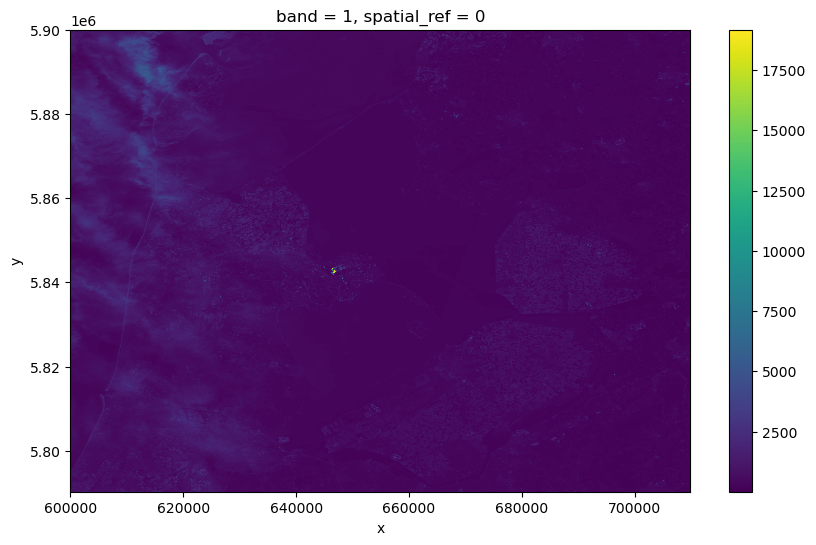

In [9]:
# Plot the raster image
import matplotlib.pyplot as plt

# Plot the raster data
fig, ax = plt.subplots(figsize=(10, 6))
b01[0,:,:].plot.imshow(ax=ax, cmap='viridis')
plt.show()

In [10]:
# Save the raster image to disk
b01.rio.to_raster("B01.tif")

## Viewing other raster properties

In [11]:
#Coordinate reference system
print(b01.rio.crs)
#Areas with no data
print(b01.rio.nodata)
#image bounds
print(b01.rio.bounds())
#image size
print(b01.rio.width)
print(b01.rio.height)

EPSG:32631
0
(600000.0, 5790240.0, 709800.0, 5900040.0)
1830
1830


We can query the coordinate reference system in more depth

In [12]:
from pyproj import CRS
epsg = b01.rio.crs.to_epsg()
crs = CRS(epsg)
crs

<Projected CRS: EPSG:32631>
Name: WGS 84 / UTM zone 31N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 0°E and 6°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Andorra. Belgium. Benin. Burkina Faso. Denmark - North Sea. France. Germany - North Sea. Ghana. Luxembourg. Mali. Netherlands. Niger. Nigeria. Norway. Spain. Togo. United Kingdom (UK) - North Sea.
- bounds: (0.0, 0.0, 6.0, 84.0)
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

* Name of the projection is UTM zone 31N (UTM has 60 zones, each 6-degrees of longitude in width). 
* The underlying datum is WGS84.
* Axis Info: the CRS shows a Cartesian system with two axes, easting and northing, in meter units.
* Area of Use: the projection is used for a particular range of longitudes 0°E to 6°E in the northern hemisphere (0.0°N to 84.0°N)
* Coordinate Operation: the operation to project the coordinates (if it is projected) onto a cartesian (x, y) plane. Transverse Mercator is accurate for areas with longitudinal widths of a few degrees, hence the distinct UTM zones.
* Datum: Details about the datum, or the reference point for coordinates. WGS 84 and NAD 1983 are common datums. NAD 1983 is set to be replaced in 2022.


## Calculating raster statistics

In [13]:
print(b01.min())
print(b01.max())
print(b01.mean())
print(b01.std())

<xarray.DataArray ()>
array(1, dtype=uint16)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(19176, dtype=uint16)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(573.66220192)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(502.44108139)
Coordinates:
    spatial_ref  int64 0


We could also do this with numpy

In [14]:
import numpy as np
print(np.min(b01))
print(np.max(b01))
print(np.mean(b01))
print(np.std(b01))

<xarray.DataArray ()>
array(1, dtype=uint16)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(19176, dtype=uint16)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(573.66220192)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(502.44108139)
Coordinates:
    spatial_ref  int64 0


## Using rioxarray to mask "nodata" values

When we inspected the band 1 raster we saw that the value that represents a "nodata" reading is zero. Sometimes we want "nodata" to be set to nan so that we know to exclude it from an analysis. Let's load a different band and set the "masked" argument to true. This will set the "nodata" value from 0 to NaN. This is helpful if you don't want to include "nodata" values in your analysis.

In [15]:
b9 = rioxarray.open_rasterio(asset["B09"]['href'], masked=True)

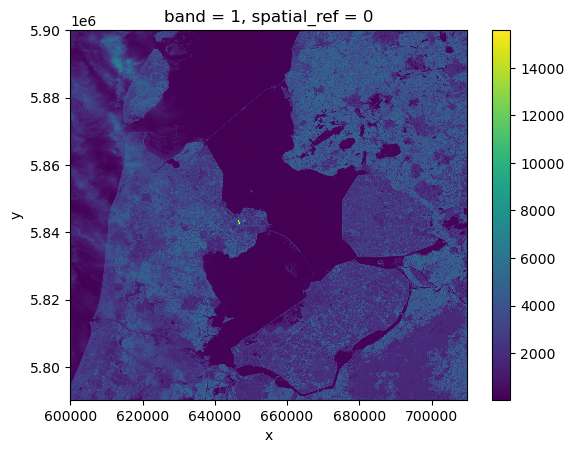

In [16]:
#lets plot. Notice how now the values on the left side of the image aren't plotted
b9.plot()

## Using vector data to crop raster data

Earlier we used a point geometry to filter out the Sentinel 2 collection to only include scenes that intersected a point. Vector geometries can interact with raster data in other ways and we'll explore using vectors to crop raster data and to calculate raster statistics wihin certain zones delineated by vector data.

Before doing this let's do:

### a quick introduction to the python library geopandas.

Geopandas extends pandas by adding features relevant to geospatial analysis and adding support for vector geometries through the python shapely library. We will be be working with polygon crop field boundaries, waterway line geometries, and ground water well locations (point geometries).

Let's import geopandas and define an Area of Interest to work within. All the crop field boundaries are taken from the Netherlands so we will be working in an AoI within there.

In [17]:
import geopandas as gpd

In [18]:
# define a bounding box in northern Amsterdam.  This will be our Area of Interest (AoI)
xmin, xmax = (110_000, 140_000)
ymin, ymax = (470_000, 510_000)
bbox = (xmin, ymin, xmax, ymax)

#### Loading data

Now that we have defined our AoI we can load our data we can load it.

In [22]:
# Partially load data within the bounding box
cropfield = gpd.read_file("./brpgewaspercelen_definitief_2020_small.gpkg", bbox=bbox)

DriverError: home/jovyan/data/RasterVectorPython/brpgewaspercelen_definitief_2020_small.gpkg: No such file or directory

### Inspecting metadata of imported geometries

In [ ]:
cropfield.type

In [ ]:
cropfield.crs

In [ ]:
cropfield.total_bounds

The call to "total_bounds" gave us the extent of the imported geometries. The extent of the dataset is defined as the bounding box that contains al the geometries.

### Cropping data within AoI

In [ ]:
# Define a Boundingbox in RD
xmin, xmax = (120_000, 135_000)
ymin, ymax = (485_000, 500_000)
cropfield_crop = cropfield.cx[xmin:xmax, ymin:ymax]
cropfield_crop.total_bounds

### Saving this subset of the data

In [ ]:
cropfield_crop.to_file('cropped_field.shp')

### Plotting our cropped geometries

Geopandas can call matplotlib to plot the geometries we have imported.

In [ ]:
cropfield_crop.plot()

In [ ]:
# Set some options
cropfield_crop.plot(figsize=(10,10), edgecolor="purple", facecolor="None")

### Importing waterway and well data

Now let's import some line geometries that represt flowlines of waterways going through our AoI

In [ ]:
waterways_nl = gpd.read_file("./status_vaarweg.zip")
wells = gpd.read_file("./brogmwvolledigeset.zip")

In [ ]:
waterways_nl.plot()

In [ ]:
wells.plot()

### Correcting flipped latitude and longitude in the waterway data

As you can see the waterways data is flipped relative to the groundwater well data (it uses a different axis ordering). We can correct this using the shapely library.

In [ ]:
print(waterways_nl['geometry'][2])
print(type(waterways_nl['geometry'][2]))

In [ ]:
import shapely

# Define a function flipping the x and y coordinate values
def flip(geometry):
    return shapely.ops.transform(lambda x, y: (y, x), geometry)

# Apply this function to all coordinates and all lines
geom_corrected = waterways_nl['geometry'].apply(flip)

In [ ]:
# Update geometry
waterways_nl['geometry'] = geom_corrected

# Visualization
waterways_nl.plot()

## Cropping satellite imagery with crop field data

We're now going to use the vector data we imported to crop the satellite data we loaded from the STAC catalog in the first part of the tutorial. First let's look at a true color image of the AoI of the sentinal 2 bands that we queried. 

In [ ]:
true_color_image = rioxarray.open_rasterio(asset["visual"]["href"]) # Select a true color image

In [ ]:
print(true_color_image.shape)


In [ ]:
# Get the overview asset
overview_image = rioxarray.open_rasterio(asset["overview"]["href"])
print(overview_image.shape)

# Visualize it
overview_image.plot.imshow(figsize=(4,4))

### Compare the CRS of the raster data to the CRS of the vector data

In [ ]:
# Check the coordinate system
CRS(true_color_image.rio.crs)

In [ ]:
# Load the polygons of the crop fields
cf_boundary_crop = gpd.read_file("cropped_field.shp")

# Check the coordinate system
cf_boundary_crop.crs

### Convert the coordinate system of the vector data to the coordinate system of the raster data

In [ ]:
# Convert the coordinate system
cf_boundary_crop = cf_boundary_crop.to_crs(true_color_image.rio.crs)

### Overlay the crop field boundaries onto the satellite image

In [ ]:
# Plot
fig, ax = plt.subplots()
fig.set_size_inches((8,8))

# Plot image
overview_image.plot.imshow(ax=ax)

# Plot crop fields
cf_boundary_crop.plot(
    ax=ax,
    edgecolor="red",
)

### Cropping the raster data to just our AoI

In [ ]:
# Crop the raster with the bounding box
raster_clip_box = true_color_image.rio.clip_box(*cf_boundary_crop.total_bounds)
# Print the size of the original image
print(true_color_image.shape)
# print the size of the cropped image
print(raster_clip_box.shape)

### Visualize cropped image

In [ ]:
raster_clip_box.plot.imshow(figsize=(8,8))

### Further cropping to select just fields

We cropped our image to the bounds containing all our field polygons. We can further cop to select only the fields.

In [ ]:
raster_clip_fields = raster_clip_box.rio.clip(cf_boundary_crop['geometry'])

# Visualize output
raster_clip_fields.plot.imshow(figsize=(8,8))

## Plotting groundwater wells located in our AoI

In [ ]:
# Transform the well CRS to the raster CRS
wells = wells.to_crs(raster_clip_box.rio.crs)

# Crop the wells to the image extent
xmin, ymin, xmax, ymax = raster_clip_box.rio.bounds()
wells = wells.cx[xmin:xmax, ymin:ymax]

In [ ]:
# Plot the wells over raster
fig, ax = plt.subplots()
fig.set_size_inches((8,8))
raster_clip_box.plot.imshow(ax=ax)
wells.plot(ax=ax, color='red', markersize=2)

## Find where wells are colated in fields

In [ ]:
# perform the spatial join
wells_in_fields = gpd.sjoin(wells, cf_boundary_crop, op='within')

fig, ax = plt.subplots()
fig.set_size_inches((8,8))
raster_clip_box.plot.imshow(ax=ax)
wells_in_fields.plot(ax=ax, color='red', markersize=2)

## Computing NDVI for the fields

Now let's demonstrate using the sentinel 2 imagery to estimate the Normalized Difference Vegetation Index (NDVI).

### What is NDVI?

$NDVI = \frac{(NIR - RED)}{(NIR + RED)}$

The NDVI is a measure of vegetation health. Healthy leaves will absorb more red visible light than unhealthy leaves. Healthy leaves should reflect light in the near infrared part of the spectrum (NIR). So if we subtract the red reflectance values in the numerator and add the value to the denominator in the NDVI formula a healthy leaves value will be closer to one since it red reflectance value will be lower.

![NDVIpic](https://carpentries-incubator.github.io/geospatial-python/fig/E09-01-PONE-NDVI.jpg)
Source: Wu C-D, McNeely E, Cedeño-Laurent JG, Pan W-C, Adamkiewicz G, Dominici F, et al. (2014) Linking Student Performance in Massachusetts Elementary Schools with the “Greenness” of School Surroundings Using Remote Sensing. PLoS ONE 9(10): e108548. https://doi.org/10.1371/journal.pone.0108548

## Load the red and the near infrared bands

In [ ]:
red_uri = asset["B04"]["href"]
nir_uri = asset["B8A"]["href"]

In [ ]:
red = rioxarray.open_rasterio(red_uri, masked=True)
nir = rioxarray.open_rasterio(nir_uri, masked=True)

## Clip to the fields

In [ ]:
red_clip = red.rio.clip(cf_boundary_crop['geometry'])
nir_clip = nir.rio.clip(cf_boundary_crop['geometry'])

## Plotting

Let's plot our clipped data. We will use the argument "robust=True" to stretch the band reflectance values between the 2nd and 98th percentile of data. This enhances the contrast of the image by getting rid of outliers.

In [ ]:
red_clip.plot(robust=True)

In [ ]:
nir_clip.plot(robust=True)

## Calculating NDVI

Now we want to use our near-infrared reflectance image and our red reflectance image to calculate NDVI. To do this we will do this by performing pixelwise operations involving our two rasters. To do this we first need to make sure our images are the right shape:

In [ ]:
print(red_clip.shape, nir_clip.shape)

Since our images were taken at different resolutions we need to reproject/resample one raster to the CRS of another raster. The "reproject_match" function in rasterio does this reprojection operation and also makes sure that the extents of both rasters match.

In [ ]:
red_clip_matched = red_clip.rio.reproject_match(nir_clip)
print(red_clip_matched.shape)

In [ ]:
ndvi = (nir_clip - red_clip_matched)/ (nir_clip + red_clip_matched)
print(ndvi)

In [ ]:
ndvi.plot()

In [ ]:
# save to disk
ndvi.rio.to_raster("ndvi.tif")

## What are the distribution of mean NDVI for the fields in this image?

We can now use the raster information in each of our field boundaries to start to get an idea for the range of crop healths in our ROI. To do this we will use the raster_stats library to compute zonal statistics.

In [ ]:
#make sure the rasterstats library is installed
!pip install rasterstats

In [ ]:
ndvipath = "ndvi.tif"

In [ ]:
from rasterstats import zonal_stats

fieldgeometries = cf_boundary_crop['geometry']

# create a list of dictionaries where each dictionary represents a polygon and contains the mean value ('mean')
stats = zonal_stats(fieldgeometries, ndvipath, stats="mean")

# Now let's extract the mean values and plot the distribution
means = [x['mean'] for x in stats if x['mean'] is not None]  # excludes polygons where the mean couldn't be computed (i.e., no raster data inside them)

plt.hist(means, bins=20)
plt.title('Distribution of Mean Raster Values per Polygon')
plt.xlabel('Mean Raster Value')
plt.ylabel('Frequency')
plt.show()

## Inspecting values in one of the least healthy fields and one of the healthier fields

In [ ]:
# Convert means to numpy array for efficient handling
means_np = np.array(means)

# Argsort gives indices that would sort the array
sorted_indices = np.argsort(means_np)

# Get the index for 50th lowest and 50th highest
index_low = sorted_indices[49]
index_high = sorted_indices[-50]

# Get the corresponding geometries
geom_low = fieldgeometries.iloc[index_low]
geom_high = fieldgeometries.iloc[index_high]

In [ ]:
# Create GeoSeries from the geometries
geom_low_gs = gpd.GeoSeries([geom_low])
geom_high_gs = gpd.GeoSeries([geom_high])

low_field = ndvi.rio.clip(geom_low_gs)
high_field = ndvi.rio.clip(geom_high_gs)

In [ ]:
low_field

In [ ]:
high_field